<img src="../logo_UTN.svg" align="right" width="200" /> 

# Tarea semanal 5
## Manuel Dieguez

# ¿Que vamos a estudiar en esta tarea?

En esta tarea vamos a estudiar formas sencillas de estimacion espectral, para esto, vamos a trabajar con una senoidal cuya frecuencia esta centrada en N/4, pero tiene una variacion aleatoria de +/- fs/(2*N). Esto quiere decir que no encaja perfectamente en un bin y se ve afectada por nuestro ventaneo implicito. Entonces, es necesario tener estimadores de parametros como la frecuencia y la amplitud ya que no podemos medirlo directamente.

La idea es estimar la amplitud mediante el estimador

$$ \hat{a} = X(\Omega) $$ 

Es decir, tomamos el valor de amplitud donde esperamos que este el pico de la senoidal, nuestro caso va a ser N/4.
En mi caso, lo voy a comparar con el estimador que toma el valor de $ X(\Omega) $ que maximiza la amplitud.

Por otra parte, para estimar la frecuencia de la senoidal, vamos a tomar la frecuencia que maximice la amplitud en el espectro, es decir:

$$ \hat{\Omega} = argmax\{X(\Omega)\}$$



In [68]:
import numpy as np
#import numpy.matlib as matlib
import scipy as sc
import matplotlib.pyplot as plt
from signal_generator import *

Vamos a generar nuestras senales de muestra, para esto vamos a generar 200 senoidales de igual amplitud, pero que presenten una variacion aleatoria en su frecuancia, de tal forma que:

$$ x(k) = a_{1}.sen(\Omega_{1}.k) + n(k)$$

Donde 

$$ \Omega_{1} = \Omega_{0} + f_{r}.\frac{2\pi}{N}$$

Siendo $ f_{r} $ una distribucion uniforme tal que

$$ f_{r} \sim \mathcal{U}(-\frac{1}{2}, \, \frac{1}{2}) $$

y el ruido una distribucion normal tal que

$$ n \sim \mathcal{N}(0, \, \sigma ^2) $$

Vamos a realizar 200 realizaciones del experimento

In [69]:
N_exp = 200 # Numero de realizaciones o experimentos

Vp = 2     # Valor pico de la senoidal
Vdc = 0    # Valor medio
fs = 1000  # frecuencia de muestreo
N = fs     # Numero de muestras
f = fs/N*(N/4)  # frecuencia de ka senal
fase = 0   # fase de la senal

## Ruido
SNR_db = 10  ## Tomamos un SNR de 10 dB
SNR = 10**(SNR_db/10)
Ps = Vp**2/2
Pn = Ps/SNR
fr = np.random.uniform(-fs/(2*N),fs/(2*N),N_exp)
t = np.linspace(0,N/fs,N)

t_matrix = np.tile(t, (N_exp,1))   # Repito el vector tiempo tantas veces como experimetos haga
fr_matrix = np.tile(fr.reshape(-1, 1), (1, len(t)))  # Repito la columna de fr tantas veces como muestras temporales haya

In [70]:
## Nuestro generador de senal va a generar nuestra senal discreta muestreada a 
## fs pero sin cuantizar su ampltiud
x_analogica   = Vdc + Vp*np.sin(2*np.pi*(f+fr_matrix)*t_matrix + fase)

## Ahora agregamos ruido a nuestra senal
n_matrix = np.random.normal(0, np.sqrt(Pn),(len(fr),len(t)))
x_matrix = x_analogica + n_matrix

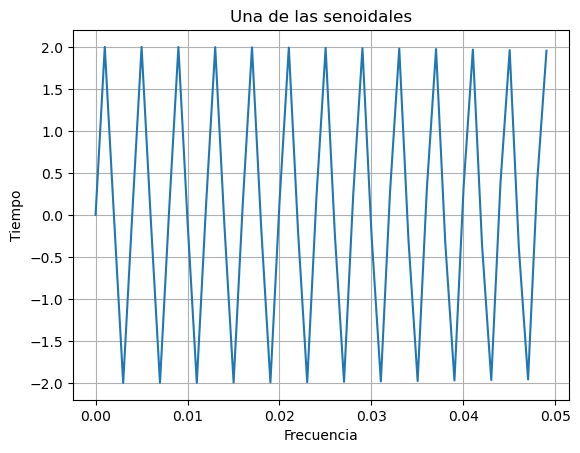


 
ADVERTENCIA 
Como estamos en N/4 la senal parece una diente de sierra
 



In [71]:
plt.figure(1)
plt.plot(t[0:50],x_analogica[143,0:50])
plt.xlabel("Frecuencia")
plt.ylabel("Tiempo")
plt.grid()
plt.title("Una de las senoidales")
#plt.legend()
plt.show()

print("\n \n\033[1mADVERTENCIA\033[0m \nComo estamos en N/4 la senal parece una diente de sierra\n \n")

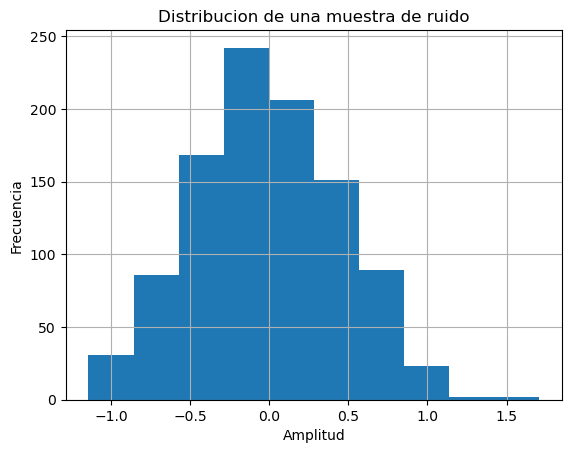

In [72]:
plt.figure(2)
plt.hist(n_matrix[3,:])
plt.ylabel("Frecuencia")
plt.xlabel("Amplitud")
plt.grid()
plt.title("Distribucion de una muestra de ruido")
plt.show()

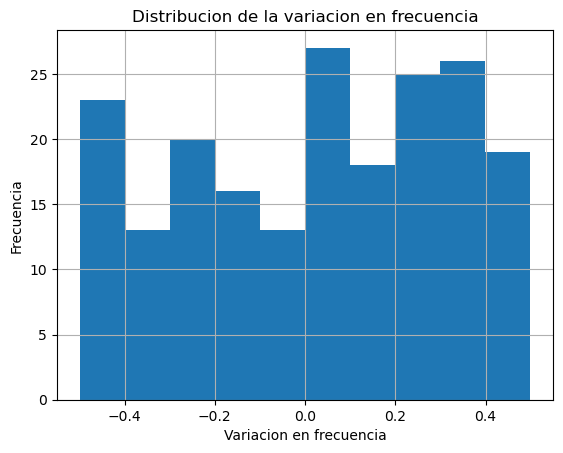

In [73]:
plt.figure(3)
plt.hist(fr)
plt.ylabel("Frecuencia")
plt.xlabel("Variacion en frecuencia")
plt.grid()
plt.title("Distribucion de la variacion en frecuencia")
plt.show()



Pasamos a realizar nuestras fft, al tenerlo ordenado matricialmente, cada fila representa la fft de ese experimento en particular

In [74]:
x_fft = np.fft.fft(x_matrix)/N
freqs = np.fft.fftfreq(N,1/fs)
bfreqs = (freqs>=0)   # Para tomar frecuencias positivas


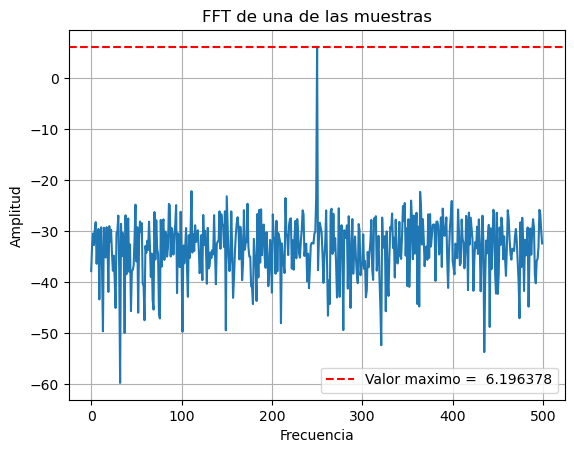

In [75]:
# Ploteamos una de las fft

plt.figure(4)
plt.plot(freqs[bfreqs],20*np.log10(2*np.abs(x_fft[10,bfreqs])))
plt.axhline(20*np.log10(2*np.abs(x_fft[10,np.argmax(np.abs(x_fft[10,bfreqs]))])), color= 'red', linestyle = 'dashed', 
            label = f'Valor maximo = {20*np.log10(2*np.abs(x_fft[10,np.argmax(np.abs(x_fft[10,bfreqs]))])): 2f}' )
plt.xlabel("Frecuencia")
plt.ylabel("Amplitud")
plt.grid()
plt.legend()
plt.title("FFT de una de las muestras")
plt.show()

## Calculo de los estimadores

Vamos a empezar estimando la amplitud de la senoidal

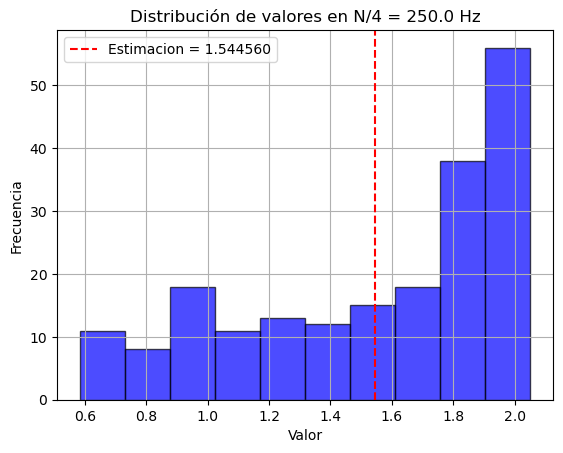


 Nuestro estimador toma los valores de amplitud en N/4 , y la media de la estimacion es 1.544560 V,tiene una varianza de 0.184623 V^2.
 Tambien presenta un sesgo o desvio de -0.455440 V




In [76]:
## Obtenemos los indices que maximizan la amplitud
indice_maxamp = np.argmax(np.abs(x_fft[:,bfreqs]),axis =1)
Vp_max = 2*np.abs(x_fft[np.arange(x_fft.shape[0]),indice_maxamp])

## Vamos a trabajar con el estimador de amplitud
a0 = 2*np.abs(x_fft[:,N//4])
Vp_est = np.mean(a0)  ## // es division entera
Vp_est_var = np.var(a0)
a0_sesgo = Vp_est - Vp

plt.figure(5)
plt.hist(a0, density=False, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(Vp_est,color = 'red', linestyle = 'dashed', label = f'Estimacion = {Vp_est:4f}')
plt.title(f'Distribución de valores en N/4 = {N/4 * fs/N } Hz')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.legend()
plt.show()

print(f"\n Nuestro estimador toma los valores de amplitud en N/4 , y la media de la estimacion es {Vp_est:2f} V,\
tiene una varianza de {Vp_est_var:2f} V^2.\n Tambien presenta un sesgo o desvio de {a0_sesgo:2f} V\n\n")

Ahora probamos estimar usando los valores maximos de amplitud, para comparar resultados

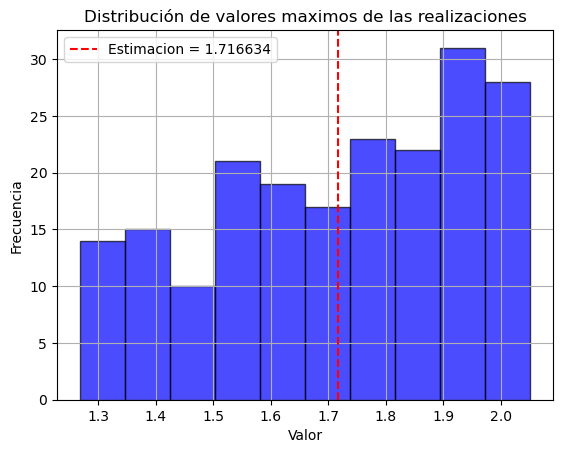


 Este estimador toma los valores maximos de amplitud, y la media de la estimacion es 1.716634 V,tiene una varianza de 0.049543 V^2.
 Tambien presenta un sesgo o desvio de -0.283366 V

Se puede observar que este estimador es un poco mas preciso ya que toma los valores maximos de amplitud "perdiendo menos potencia".Tambien se reduce significativamente la varianza


In [77]:
## Probamos otro estimador, tomando los valores de amplitud maxima
a1 = 2*np.abs(x_fft[np.arange(x_fft.shape[0]),indice_maxamp])
Vp_est2 = np.mean(a1)
Vp_est2_var = np.var(a1)
a1_sesgo = Vp_est2 - Vp

plt.figure(6)
plt.hist(a1, density=False, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(Vp_est2,color = 'red', linestyle = 'dashed', label = f'Estimacion = {Vp_est2:4f}')
plt.title('Distribución de valores maximos de las realizaciones')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.legend()
plt.show()

print(f"\n Este estimador toma los valores maximos de amplitud, y la media de la estimacion es {Vp_est2:2f} V,\
tiene una varianza de {Vp_est2_var:2f} V^2.\n Tambien presenta un sesgo o desvio de {a1_sesgo:2f} V\n\n\
Se puede observar que este estimador es un poco mas preciso ya que toma los valores maximos de amplitud \"perdiendo menos potencia\".\
Tambien se reduce significativamente la varianza")

## Estimacion de frecuencia

Vamos a estimar la frecuencia usando los valores que maximizan la amplitud en el espectro

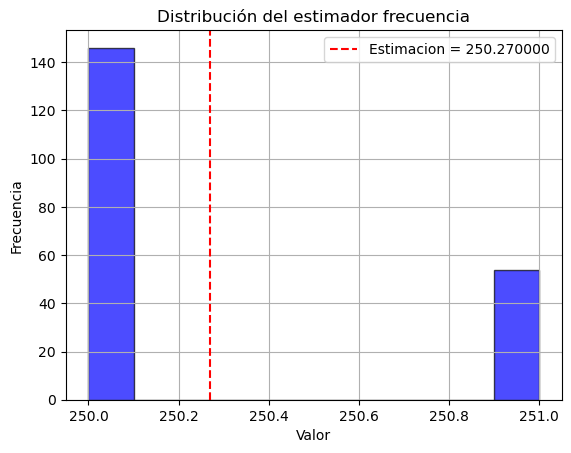


Tener en cuenta que nuestro estimador solo ppuede tomar los valores discretizados en frecuencia, es decir, multiplos de fs/N

 Este estimador toma las frecuencias en las cuales se presenta la maxima amplitud, y la media de la estimacion es 250.270000 Hz,tiene una varianza de 0.197100 Hz^2.
 Tambien presenta un sesgo o desvio de -0.283366 Hz




In [80]:
## Estimamos la frecuencia
f0 = indice_maxamp*fs/N
f_est = np.mean(f0)
f_est_var = np.var(f0)
f_sesgo = f_est - f

plt.figure(7)
plt.hist(f0, density=False, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(f_est,color = 'red', linestyle = 'dashed', label = f'Estimacion = {f_est:4f}')
plt.title('Distribución del estimador frecuencia')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.legend()
plt.show()

print("\nTener en cuenta que nuestro estimador solo ppuede tomar los valores discretizados en frecuencia, es decir, multiplos de fs/N")

print(f"\n Este estimador toma las frecuencias en las cuales se presenta la maxima amplitud, y la media de la estimacion es {f_est:2f} Hz,\
tiene una varianza de {f_est_var:2f} Hz^2.\n Tambien presenta un sesgo o desvio de {a1_sesgo:2f} Hz\n\n")